In [2]:
%matplotlib inline


# Comparison of ensembling classifiers internally using sampling


Ensembling classifiers have shown to improve classification performance compare
to single learner. However, they will be affected by class imbalance. This
example shows the benefit of balancing the training set before to learn
learners. We are making the comparison with non-balanced ensemble methods.

We make a comparison using the balanced accuracy and geometric mean which are
metrics widely used in the literature to evaluate models learned on imbalanced
set.


In [3]:
# Authors: Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: MIT

import itertools

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

from imblearn.datasets import fetch_datasets
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import RUSBoostClassifier

from imblearn.metrics import geometric_mean_score

import pandas as pd


def plot_confusion_matrix(cm, classes, ax,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print(cm)
    print('')

    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.sca(ax)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

Load an imbalanced dataset
##############################################################################
 We will load the UCI SatImage dataset which has an imbalanced ratio of 9.3:1
 (number of majority sample for a minority sample). The data are then split
 into training and testing.



In [4]:
# satimage = fetch_datasets()['satimage']
# X, y = satimage.data, satimage.target
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
#                                                     random_state=0)

train = pd.read_csv('data/wanzhou_island.csv')
train_labels = train['value']
train.head()

,Elevation,Slope,Aspect,A4,A5,A6,TRI,A8,A9,A10,...,C6,C7,C8,NDVI,NDWI,Rainfall,Earthquake,Land_use,value,ID
0,295,7.75467,284.9310,34.3289,8,0.700315,2.73861,5.08108,0.526814,33.48050,...,0.087924,2.54951,158.012,0.786250,0.326397,1134.47,1.85445,3,0,1
1,296,4.04531,352.8750,35.8758,6,0.712934,2.12132,5.70270,0.517350,53.20100,...,0.088662,2.54951,158.301,0.659509,0.255611,1134.45,1.85558,5,0,2
2,294,7.77054,45.0000,34.9304,5,0.735016,2.87228,4.02703,0.511041,-4.23753,...,0.117174,3.90513,161.590,0.610321,0.151975,1134.43,1.85671,4,0,3
3,290,9.53282,49.2364,31.0241,0,0.747634,3.67423,1.56757,0.523659,-5.49088,...,0.134222,9.89950,166.879,0.613824,0.237688,1134.47,1.85785,4,0,4
4,287,9.16787,47.2026,27.7863,4,0.760252,3.00000,1.72973,0.501577,-2.62842,...,0.139053,8.48528,171.167,0.582016,0.204665,1134.45,1.85898,4,0,5


In [5]:
# x_columns = [x for x in train.columns if x not in ['ID','value']]

x_columns = ['Elevation', 'Slope', 'Aspect', 'TRI', 'Curvature', 'Lithology', 'River', 'NDVI', 'NDWI', 'Rainfall', 'Earthquake', 'Land_use']

X, y = train[x_columns], train_labels
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

Classification using a single decision tree
##############################################################################
 We train a decision tree classifier which will be used as a baseline for the
 rest of this example.



The results are reported in terms of balanced accuracy and geometric mean
which are metrics widely used in the literature to validate model trained on
imbalanced set.



Decision tree classifier performance:
Balanced accuracy: 0.91 - Geometric mean 0.91
[[137134   1160]
 [  1274   6054]]



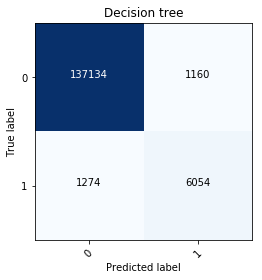

In [6]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print('Decision tree classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_tree),
              geometric_mean_score(y_test, y_pred_tree)))
cm_tree = confusion_matrix(y_test, y_pred_tree)
fig, ax = plt.subplots()
plot_confusion_matrix(cm_tree, classes=np.unique(train_labels), ax=ax,
                      title='Decision tree')

Classification using bagging classifier with and without sampling
##############################################################################
 Instead of using a single tree, we will check if an ensemble of decsion tree
 can actually alleviate the issue induced by the class imbalancing. First, we
 will use a bagging classifier and its counter part which internally uses a
 random under-sampling to balanced each boostrap sample.



In [8]:
bagging = BaggingClassifier(n_estimators=50, random_state=0)
balanced_bagging = BalancedBaggingClassifier(n_estimators=50, random_state=0)

bagging.fit(X_train, y_train)
balanced_bagging.fit(X_train, y_train)

y_pred_bc = bagging.predict(X_test)
y_pred_bbc = balanced_bagging.predict(X_test)

Balancing each bootstrap sample allows to increase significantly the balanced
accuracy and the geometric mean.



Bagging classifier performance:
Balanced accuracy: 0.92 - Geometric mean 0.92
[[137879    415]
 [  1088   6240]]

Balanced Bagging classifier performance:
Balanced accuracy: 0.97 - Geometric mean 0.97
[[133371   4923]
 [   148   7180]]



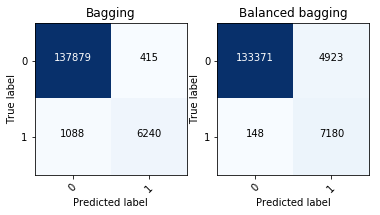

In [22]:
print('Bagging classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_bc),
              geometric_mean_score(y_test, y_pred_bc)))
cm_bagging = confusion_matrix(y_test, y_pred_bc)
fig, ax = plt.subplots(ncols=2)
plot_confusion_matrix(cm_bagging, classes=np.unique(train_labels), ax=ax[0],
                      title='Bagging')

print('Balanced Bagging classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_bbc),
              geometric_mean_score(y_test, y_pred_bbc)))
cm_balanced_bagging = confusion_matrix(y_test, y_pred_bbc)
plot_confusion_matrix(cm_balanced_bagging, classes=np.unique(train_labels),
                      ax=ax[1], title='Balanced bagging')

Classification using random forest classifier with and without sampling
##############################################################################
 Random forest is another popular ensemble method and it is usually
 outperforming bagging. Here, we used a vanilla random forest and its balanced
 counterpart in which each bootstrap sample is balanced.



Random Forest classifier performance:
Balanced accuracy: 0.83 - Geometric mean 0.81
[[138067    227]
 [  2470   4858]]

Balanced Random Forest classifier performance:
Balanced accuracy: 0.94 - Geometric mean 0.94
[[124758  13536]
 [   176   7152]]



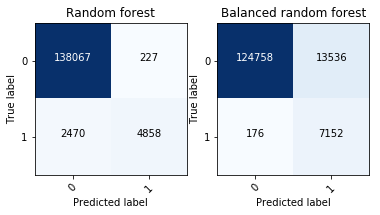

In [24]:
rf = RandomForestClassifier(n_estimators=50, random_state=0)
brf = BalancedRandomForestClassifier(n_estimators=50, random_state=0)

rf.fit(X_train, y_train)
brf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_pred_brf = brf.predict(X_test)

# Similarly to the previous experiment, the balanced classifier outperform the
# classifier which learn from imbalanced bootstrap samples. In addition, random
# forest outsperforms the bagging classifier.

print('Random Forest classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_rf),
              geometric_mean_score(y_test, y_pred_rf)))
cm_rf = confusion_matrix(y_test, y_pred_rf)
fig, ax = plt.subplots(ncols=2)
plot_confusion_matrix(cm_rf, classes=np.unique(train_labels), ax=ax[0],
                      title='Random forest')

print('Balanced Random Forest classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_brf),
              geometric_mean_score(y_test, y_pred_brf)))
cm_brf = confusion_matrix(y_test, y_pred_brf)
plot_confusion_matrix(cm_brf, classes=np.unique(train_labels), ax=ax[1],
                      title='Balanced random forest')

Boosting classifier
##############################################################################
 In the same manner, easy ensemble classifier is a bag of balanced AdaBoost
 classifier. However, it will be slower to train than random forest and will
 achieve worse performance.



Easy ensemble classifier performance:
Balanced accuracy: 0.79 - Geometric mean 0.79
[[105046  33248]
 [  1353   5975]]

RUSBoost classifier performance:
Balanced accuracy: 0.80 - Geometric mean 0.79
[[102343  35951]
 [  1081   6247]]



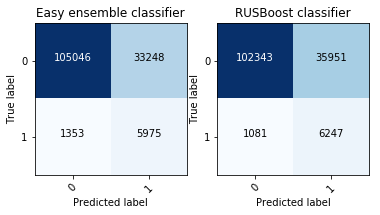

In [26]:
base_estimator = AdaBoostClassifier(n_estimators=10)
eec = EasyEnsembleClassifier(n_estimators=10,
                             base_estimator=base_estimator)
eec.fit(X_train, y_train)
y_pred_eec = eec.predict(X_test)
print('Easy ensemble classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_eec),
              geometric_mean_score(y_test, y_pred_eec)))
cm_eec = confusion_matrix(y_test, y_pred_eec)
fig, ax = plt.subplots(ncols=2)
plot_confusion_matrix(cm_eec, classes=np.unique(train_labels), ax=ax[0],
                      title='Easy ensemble classifier')

rusboost = RUSBoostClassifier(n_estimators=10,
                              base_estimator=base_estimator)
rusboost.fit(X_train, y_train)
y_pred_rusboost = rusboost.predict(X_test)
print('RUSBoost classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_rusboost),
              geometric_mean_score(y_test, y_pred_rusboost)))
cm_rusboost = confusion_matrix(y_test, y_pred_rusboost)
plot_confusion_matrix(cm_rusboost, classes=np.unique(train_labels),
                      ax=ax[1], title='RUSBoost classifier')

plt.show()

In [6]:
from sklearn import datasets, neighbors
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import numpy as np

LW = 2
RANDOM_STATE = 42

class DummySampler:

    def sample(self, X, y):
        return X, y

    def fit(self, X, y):
        return self

    def fit_resample(self, X, y):
        return self.sample(X, y)


cv = StratifiedKFold(n_splits=3)
classifier = ['3NN', neighbors.KNeighborsClassifier(3)]

samplers = [
    ['Standard', DummySampler()],
    ['ADASYN', ADASYN(random_state=RANDOM_STATE)],
    ['ROS', RandomOverSampler(random_state=RANDOM_STATE)],
    ['SMOTE', SMOTE(random_state=RANDOM_STATE)],
]

pipelines = [
    ['{}-{}'.format(sampler[0], classifier[0]),
     make_pipeline(sampler[1], classifier[1])]
    for sampler in samplers
]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for name, pipeline in pipelines:
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    for train, test in cv.split(X, y):
        probas_ = pipeline.fit(X[train], y[train]).predict_proba(X[test])
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        mean_tpr /= cv.get_n_splits(X, y)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, linestyle='--',
             label='{} (area = %0.2f)'.format(name) % mean_auc, lw=LW)

plt.plot([0, 1], [0, 1], linestyle='--', lw=LW, color='k',
         label='Luck')

# make nice plotting
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')

plt.legend(loc="lower right")

plt.show()

NameError: name 'np' is not defined